# MLFinance
Machine learning in finance


## Task 1 (DONE)
1) Приблизить формулу Блэка Шоулза с помощью нейронки
2) Обучающие данные сэмплировать из равномерного распределения
3) Оценить качество модели по таргетам
## Task 2 (DONE)
1) По полученной аппроксимации посчитать греки
2) Проверить качество греков по таргетам


### Black-Scholes formula

$$
V^{\text{call}} = S\Phi(d_1) - e^{-rT}K\Phi(d_2), \quad
V^{\text{put}} = e^{-rT} K\Phi(-d_2) -S\Phi(-d_1),
$$
where $\Phi(x)$ is the standard normal cumulative distribution function, and
$$
d_1 = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{S}{K} 
  + \biggl(r+\frac{\sigma^2}{2}\biggr) (T - t)\biggr), \qquad 
d_2 = \frac{1}{\sigma\sqrt{(T - t)}} \biggl(\ln\frac{S}{K} 
  + \biggl(r-\frac{\sigma^2}{2}\biggr) (T - t)\biggr).
$$
**Note**: the option price is monotone as a function of $\sigma$.
We can invert the Black-Scholes formula to obtain
$$
\sigma^{IV} = V^{-1}(p),
$$
where $p$ is the observed market price.

* Возьмем часть кода (реализация греков ) с семинаров Веги по стох волатильности

In [282]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

In [3]:
from Market.market import CallStockOption,PutStockOption,MarketState,BSParams
from Market.market import price,delta,gamma,theta,vega,rho

## Visualization prices (from vega seminar)

In [5]:
strikes = np.linspace(50, 150, 5)
times = np.linspace(0, 2, 4)
calls = CallStockOption(strike_price=strikes,
                        expiration_time=times[:, None])
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:, None])
ms = MarketState(stock_price=100, interest_rate=0.1)

params = BSParams(volatility=0.2)

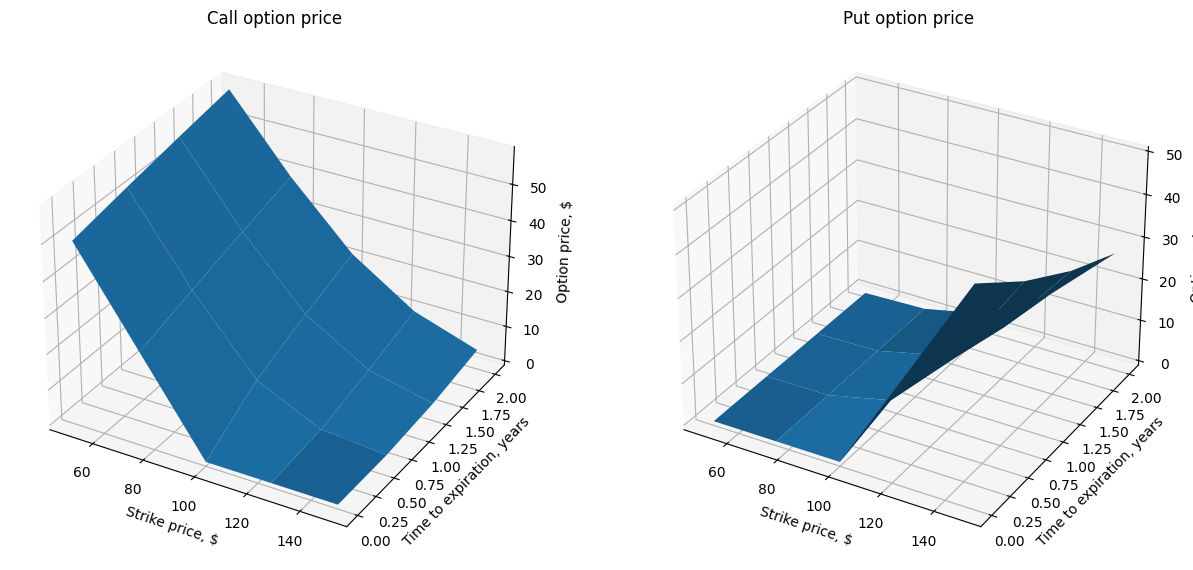

In [6]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

## Model: MLP

* Попробуем предсказывать price для пут опциона

* $V(S, K, T, t, r, \sigma)$

* $T$: option.expiration_time
* $K$: option.strike_price
* $\sigma$: params.volatility
* $t$: ms.time
* $r$: ms.interest_rate
* $S$: ms.stock_price

In [4]:
class OptionDataset(Dataset):
    def __init__(self, num_samples, params):
        """
        num_samples: Number of objects
        params_range: should be dict(
                                    T = tuple([minT,maxT]) ,
                                    K = tuple([minK,maxK]) ,
                                    sigma = tuple([minsigma,maxsigma]) ,
                                    r = tuple([minr,maxr]) ,
                                    S = tuple([mins,maxs]) ,
                                    )
        """
        self.num_samples = num_samples
        self.params = params
        self.data = self.generate_data()
    def generate_data(self):
        data = []
        for _ in tqdm(range(self.num_samples)):
            T = np.random.uniform(self.params['T'][0], self.params['T'][1])  # expiration_time
            K = np.random.uniform(self.params['K'][0], self.params['K'][1])  # strike_price
            sigma = np.random.uniform(self.params['sigma'][0], self.params['sigma'][1])  # volatility
            t = np.random.uniform(0,T)  # current time
            r = np.random.uniform(self.params['r'][0], self.params['r'][1])  # interest_rate
            S = np.random.uniform(self.params['S'][0], self.params['S'][1])  # stock_price
            
            puts = PutStockOption(strike_price=K, expiration_time=T)
            ms = MarketState(stock_price=S, interest_rate=r)
            params = BSParams(volatility=sigma)
            option_price = price(puts, ms, params)
            data.append([S, K, T, t, r, sigma, option_price])
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]
        features = torch.tensor(sample[:-1], dtype=torch.float32)
        target = torch.tensor(sample[-1], dtype=torch.float32)
        return features, target

In [316]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.ln1 = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.ln1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [317]:
params_train_dataset = dict(
    T = tuple([0.1,4.0]) ,
    K = tuple([50, 150]) ,
    sigma = tuple([0.05, 0.5]) ,
    r = tuple([0.05, 0.3]) ,
    S = tuple([50, 150]) ,
)

In [279]:
batch_size = 32
train_size = 10000
test_size = 1000
val_size = 100 
train_dataset = OptionDataset(train_size, params=params_train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = OptionDataset(val_size, params=params_train_dataset)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataset = OptionDataset(test_size, params=params_train_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 1000/1000 [00:00<00:00, 1030.03it/s]


In [318]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, target in dataloader:
            outputs = model(features)
            loss = criterion(outputs, target.unsqueeze(1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

def plot_losses(train_losses, val_losses):
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(*np.array(train_losses).T, label='Train Loss')
    plt.plot(*np.array(val_losses).T, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [319]:
input_size = 6
hidden_size = 128
output_size = 1
model = MLP(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.Adagrad(model.parameters(), lr=0.001) 
num_epochs = 200

<Figure size 640x480 with 0 Axes>

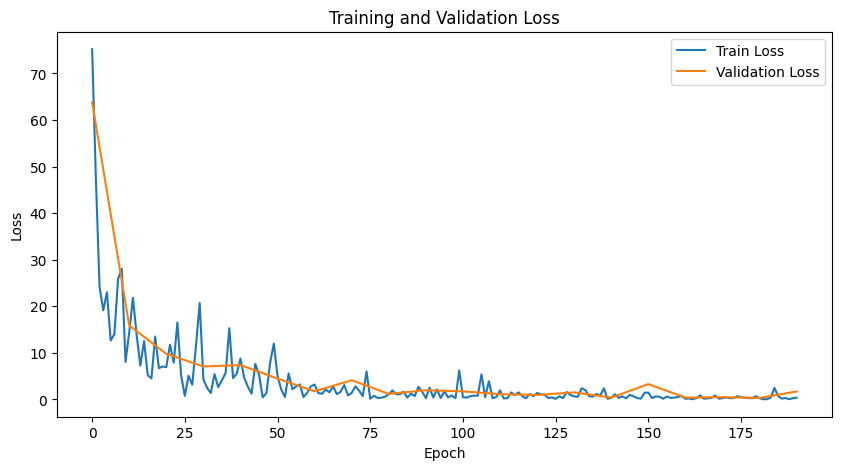

Train Loss: 0.3668, Val Loss: 1.7127
Training complete
Test Loss: 0.2909


In [320]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    for i, (features, target) in enumerate(train_dataloader):
        outputs = model(features)
        loss = criterion(outputs, target.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append((epoch , loss.item()))

    if (epoch ) % 10 == 0: 
        val_loss = evaluate(model, val_dataloader, criterion)
        val_losses.append((epoch,val_loss))
        if len(val_losses) > 1:
            clear_output(wait=False)
            plot_losses(train_losses, val_losses)
            print(f'Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

       
print("Training complete")

# Тестирование
test_loss = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.4f}')

* save

In [321]:
checkpoint_path = 'MLP.pth'

In [322]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, checkpoint_path)

* load checkpoint

In [323]:
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## Visualization + comparison

In [341]:
strikes = np.linspace(25, 200, 100)
times = np.linspace(0, 4, 100)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:, None])
ms = MarketState(stock_price=100, interest_rate=0.1)
params = BSParams(volatility=0.2)

In [342]:
%%time
put_prices = price(puts, ms, params)
put_prices.shape

CPU times: user 7.43 ms, sys: 21 µs, total: 7.45 ms
Wall time: 5.82 ms


(100, 100)

In [343]:
params_grid = np.array([[[ms.stock_price, strike, T, ms.time, ms.interest_rate, params.volatility] for strike in strikes] for T in times ] )
params_tensor = torch.tensor(params_grid, dtype=torch.float32)
params_tensor.shape

torch.Size([100, 100, 6])

In [344]:
%%time
model.eval()
with torch.no_grad():
    model_predictions = model(params_tensor).numpy()
model_predictions.shape

CPU times: user 31.4 ms, sys: 1.99 ms, total: 33.4 ms
Wall time: 19.9 ms


(100, 100, 1)

In [345]:
model_put_prices = model_predictions.squeeze()
model_put_prices.shape

(100, 100)

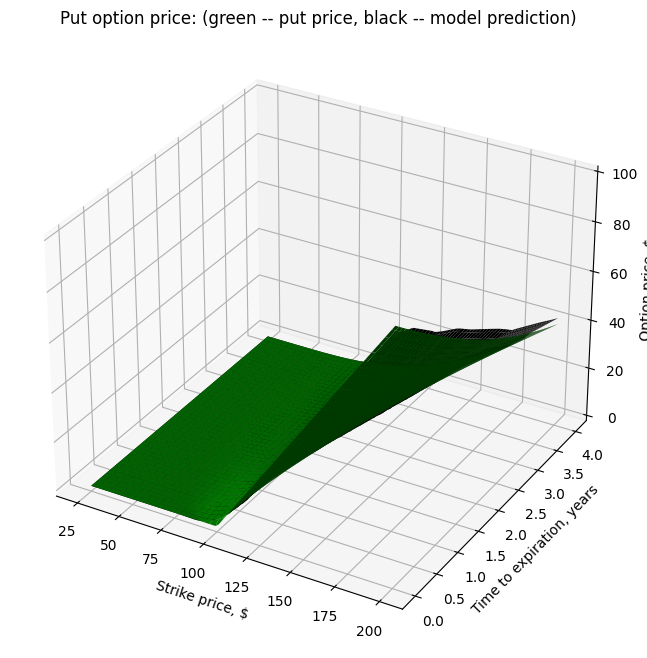

In [346]:
x, y = np.meshgrid(strikes, times)
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(x, y, put_prices, color = 'green')#, label = 'Put prices')
ax1.plot_surface(x, y, model_put_prices, color = 'black')#, label = 'Put predictions (MLP)')
ax1.set_title('Put option price: (green -- put price, black -- model prediction)')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

plt.show()

## Greeks computation

### Greeks

Delta 
$$\Delta^{call} = \displaystyle \frac{\partial V^{call}}{\partial S} = \Phi(d_1)$$
$$\Delta^{put} = \displaystyle \frac{\partial V^{put}}{\partial S} = -\Phi(-d_1) = \Phi(d_1) - 1$$

Gamma
$$
\Gamma = \displaystyle\frac{\partial^{2} V}{\partial S^{2}} = \frac{\Phi'(d_1)}{S\sigma\sqrt{T - t}}
$$

Vega
$$
\mathcal{V} = \displaystyle \frac{\partial V}{\partial \sigma} = S \Phi'(d_1) \sqrt{T-t}
$$

Theta
$$
\theta^{call} = \displaystyle \frac{\partial V^{call}}{\partial t} = 
\frac{S \Phi'(d_1) \sigma}{2 \sqrt{T - t}} - rKe^{-r(T - t)}\Phi(d_2)
$$
$$
\theta^{put} = \displaystyle \frac{\partial V^{put}}{\partial t} =
\frac{S \Phi'(d_1) \sigma}{2 \sqrt{T - t}} + rKe^{-r(T - t)}\Phi(-d_2)
$$

Rho
$$
\rho^{call} = \displaystyle \frac{\partial V^{call}}{\partial r} = 
K(T - t)e^{-r(T - t)}\Phi( d_2)
$$
$$
\rho^{put} = \displaystyle \frac{\partial V^{put}}{\partial r} =
-K(T - t)e^{-r(T - t)}\Phi(-d_2)
$$

## In MLP: with autograd

Delta 
$$\Delta^{put} = \displaystyle \frac{\partial V^{put}}{\partial S} = \nabla_S f$$

Gamma
$$
\Gamma = \displaystyle\frac{\partial^{2} V}{\partial S^{2}} = \nabla_S^2 f
$$

Vega
$$
\mathcal{V} = \displaystyle \frac{\partial V}{\partial \sigma} = \nabla_{\sigma} f
$$

Theta
$$
\theta^{put} = \displaystyle \frac{\partial V^{put}}{\partial t} = \nabla_t f
$$

Rho
$$
\rho^{put} = \displaystyle \frac{\partial V^{put}}{\partial r} = \nabla_r f
$$

$$x = [S, K, T, t, r, \sigma]$$
$$y = model(x)$$

In [330]:
def derivative(x, model = model):    
    x.requires_grad = True
    y = model(x)
    y.backward(torch.ones_like(y) , create_graph=True)
    first_derivative = x.grad
    return first_derivative

def new_delta(x, model = model):
    grad = derivative(x)
    return grad.select(-1, 0)
def new_vega(x, model = model):
    grad = derivative(x)
    return grad.select(-1, 5)
def new_theta(x, model = model):
    grad = derivative(x)
    return grad.select(-1, 3)
def new_rho(x, model = model):
    grad = derivative(x)
    return grad.select(-1, 4)

def new_gamma(x, model = model):
    return torch.autograd.functional.hessian(model, x)

In [331]:
strikes = np.linspace(50, 150, 10)
times = np.linspace(0, 2, 10)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:,None])
ms = MarketState(stock_price=100, interest_rate=0.1)
params = BSParams(volatility=0.2)

In [332]:
params_grid = np.array([[[ms.stock_price, strike, T, ms.time, ms.interest_rate, params.volatility] for strike in strikes] for T in times ] )
params_tensor = torch.tensor(params_grid, dtype=torch.float32)
params_tensor.shape

torch.Size([10, 10, 6])

In [333]:
BSM_delta = delta(puts,ms,params)
BSM_gamma = gamma(puts,ms,params)
BSM_vega = vega(puts,ms,params)
BSM_theta = theta(puts,ms,params)
BSM_rho = rho(puts,ms,params)

Model_delta = new_delta(params_tensor).detach().numpy()
Model_gamma = torch.Tensor([[new_gamma(tensor)[0][0] for tensor in slice_1] for slice_1 in params_tensor] ).detach().numpy()
Model_vega = new_vega(params_tensor).detach().numpy()
Model_theta = new_theta(params_tensor).detach().numpy()
Model_rho = new_rho(params_tensor).detach().numpy()

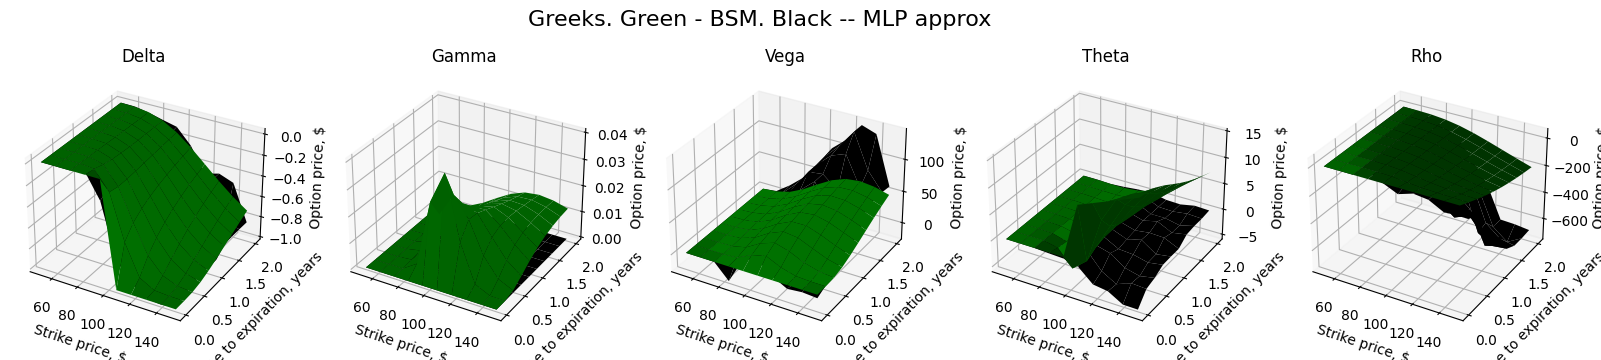

In [334]:
x, y = np.meshgrid(strikes, times)
fig = plt.figure(figsize=(20, 4))

ax1 = fig.add_subplot(151, projection='3d')
ax1.plot_surface(x, y, BSM_delta, color = 'green')#, label = 'Put prices')
ax1.plot_surface(x, y, Model_delta, color = 'black')#, label = 'Put predictions (MLP)')
ax1.set_title('Delta')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(152, projection='3d')
ax2.plot_surface(x, y, BSM_gamma, color = 'green')#, label = 'Put prices')
ax2.plot_surface(x, y, Model_gamma, color = 'black')#, label = 'Put predictions (MLP)')
ax2.set_title('Gamma')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

ax3 = fig.add_subplot(153, projection='3d')
ax3.plot_surface(x, y, BSM_vega, color = 'green')#, label = 'Put prices')
ax3.plot_surface(x, y, Model_vega, color = 'black')#, label = 'Put predictions (MLP)')
ax3.set_title('Vega')
ax3.set_xlabel('Strike price, $')
ax3.set_ylabel('Time to expiration, years')
ax3.set_zlabel('Option price, $')

ax4 = fig.add_subplot(154, projection='3d')
ax4.plot_surface(x, y, BSM_theta, color = 'green')#, label = 'Put prices')
ax4.plot_surface(x, y, Model_theta, color = 'black')#, label = 'Put predictions (MLP)')
ax4.set_title('Theta')
ax4.set_xlabel('Strike price, $')
ax4.set_ylabel('Time to expiration, years')
ax4.set_zlabel('Option price, $')

ax5 = fig.add_subplot(155, projection='3d')
ax5.plot_surface(x, y, BSM_rho, color = 'green')#, label = 'Put prices')
ax5.plot_surface(x, y, Model_rho, color = 'black')#, label = 'Put predictions (MLP)')
ax5.set_title('Rho')
ax5.set_xlabel('Strike price, $')
ax5.set_ylabel('Time to expiration, years')
ax5.set_zlabel('Option price, $')

fig.suptitle('Greeks. Green - BSM. Black -- MLP approx', fontsize=16)

plt.show()